## Методы калибровки вероятностей

Импортируем необходимые для работы модули:

In [1]:
import warnings
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
np.seterr(divide = 'ignore') 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from matplotlib import cm

from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from tqdm import tqdm

In [2]:
def plot_observations(X, y):
    plt.scatter(X[np.where(y==0), 0], X[np.where(y==0), 1], )
    plt.scatter(X[np.where(y==1), 0], X[np.where(y==1), 1], )
    plt.plot([0, 0], [-10, 10], color='grey', lw=1)
    plt.plot([-10, 10], [0, 0], color='grey', lw=1)
    plt.xlim(-2, 3)
    plt.ylim(-1.5, 2)
    return plt

In [3]:
def plot_decision_boundary(X, y, model):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    Z = model.predict(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)
    plt.contourf(x1, x2, Z, alpha=0.3, colors=['steelblue', 'orange'], levels=[-1, 0, 1])

### Подготовка данных:

Сгенерируем данные с помощью метода `make_moons`:

In [4]:
X, y = make_moons(n_samples=2000, noise=0.4, shuffle=True, random_state=12)

По умолчанию метод `make_moons` в качестве меток класса возвращает значения $y\in\{0, 1\}$. В данном ноутбуке для демонстрации методов калибровки мы будем использовать метод классификации AdaBoost, который работает с метками $y\in\{-1, +1\}$. Поэтому трансформируем метки класса:

In [5]:
class_labels = (y-0.5)*2

Разделим выборку из тысячи экземпляров на три подвыборки - обучение, валидация, тест:

In [6]:
X_train, y_train, class_labels_train = X[:800], y[:800], class_labels[:800]
X_val, y_val, class_labels_val = X[800:1400], y[800:1400], class_labels[800:1400]
X_test, y_test, class_labels_test = X[1400:], y[1400:], class_labels[1400:]

print(X_train.shape, y_train.shape, class_labels_train.shape)
print(X_val.shape, y_val.shape, class_labels_val.shape)
print(X_test.shape, y_test.shape, class_labels_test.shape)

(800, 2) (800,) (800,)
(600, 2) (600,) (600,)
(600, 2) (600,) (600,)


Изобразим полученные выборки на графике:

Text(0.5,0,'$x_1$ feature')

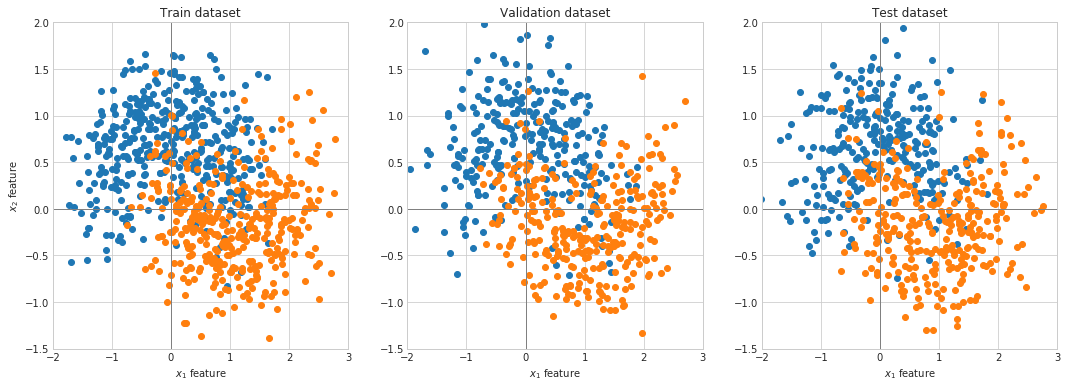

In [7]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt = plot_observations(X_train, y_train)
plt.title('Train dataset')
plt.xlabel('$x_1$ feature')
plt.ylabel('$x_2$ feature')

plt.subplot(132)
plt = plot_observations(X_val, y_val)
plt.title('Validation dataset')
plt.xlabel('$x_1$ feature')

plt.subplot(133)
plt = plot_observations(X_test, y_test)
plt.title('Test dataset')
plt.xlabel('$x_1$ feature')

Обучим модель AdaBoost на обучающей выборке. Для этого воспользуемся готовой реализацией `AdaBoostClassifier` из `sklearn`:

In [8]:
adaboost = AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=1)
adaboost.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=1)

Изобразим полученную границу раздела классов и применим ее ко всем выборкам:

Text(0.5,0,'$x_1$ feature')

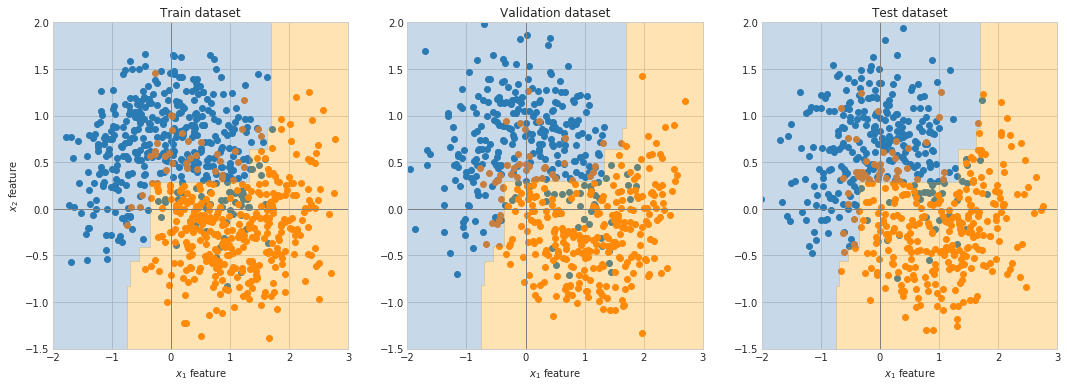

In [9]:
plt.figure(figsize=(18, 6))

plt.subplot(131)
plot_observations(X_train, y_train)
plot_decision_boundary(X_train, y_train, adaboost)
plt.title('Train dataset')
plt.xlabel('$x_1$ feature')
plt.ylabel('$x_2$ feature')

plt.subplot(132)
plot_observations(X_val, y_val)
plot_decision_boundary(X_val, y_val, adaboost)
plt.title('Validation dataset')
plt.xlabel('$x_1$ feature')

plt.subplot(133)
plot_observations(X_test, y_test)
plot_decision_boundary(X_test, y_test, adaboost)
plt.title('Test dataset')
plt.xlabel('$x_1$ feature')

-------
### Калибровка моделей:

Так как AdaBoost выдает не вероятности принадлежности к классу, а просто метки (выбранные с помощью взвешенного голосования пней), нам нужно трансформировать их в вероятности. Для этого воспользуемся следующей формулой:

$$P(y=1|x) = \frac{\sum_{t=1}^T \alpha_t \mathbb{I} [h_t(x_i)=1]}{\sum_{t=1}^T \alpha_t}$$

В этой формуле вероятность принадлежности классу $+1$ вычисляется как сумма весов базовых моделей $\alpha_t$ (в нашем случае это решающие пни $h_t(x_i)$), проголосовавших за класс $+1$, разеделеная на сумму всех весов. Данная величина изменяется в отрезке $[0, 1]$ и нам удобно ее использовать в качестве вероятности. В формуле T - это количество базовых моделей.

In [10]:
def compute_probability(X, model):
    estimators = model.estimators_
    T = len(estimators)
    estimator_weights = model.estimator_weights_
    margin = 0
    for t in range(T):
        alpha_t = estimator_weights[t]
        h_t = estimators[t].predict(X)
        h_t[h_t==-1] = 0
        margin += h_t*alpha_t
    return margin/sum(estimator_weights)

In [11]:
p_val = compute_probability(X_val, adaboost)
p_test = compute_probability(X_test, adaboost)

Посмотрим на полученные вероятности:

Text(0.5,0,'Uncalibrated value of P(y=1|X)')

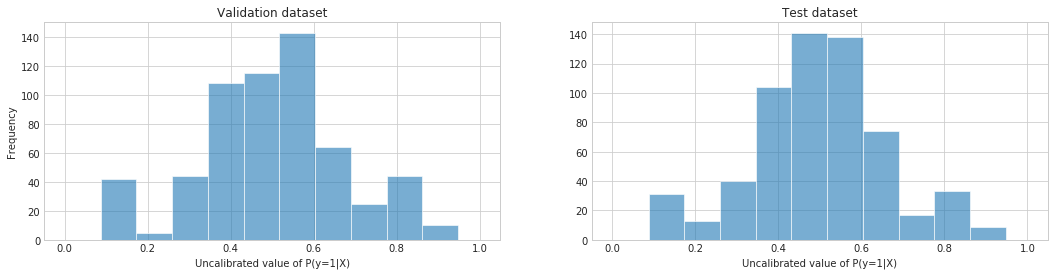

In [12]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(p_val, alpha=0.6, ec='white')
plt.xlim(-0.05, 1.05)
plt.title('Validation dataset')
plt.xlabel('Uncalibrated value of P(y=1|X)')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(p_test, alpha=0.6, ec='white')
plt.xlim(-0.05, 1.05)
plt.title('Test dataset')
plt.xlabel('Uncalibrated value of P(y=1|X)')

Из построенных гистограмм видно, что предсказанные AdaBoost-ом вероятности "скучены" к центру и на валидации, и на тесте. Это в целом согласуется с тем, что для margin-based методов (AdaBoost, SVM) характерным распределением оцененных вероятностей является именно "горка" с центром в середине.

Здесь важно понимать, что такое распределение получилось благодаря настройкам в генерации данных. В случае, если бы параметр `noise` в `make_moons` был бы меньше, и данные (как следствие) были бы лучше разделимы, то распределение предсказанных вероятностей было бы совсем другое (оно было бы похоже на два "горба" по краям)! Поэтому характер распределений и необходимость калибровки нужно всегда проверять _на конкретной задаче и на конкретных данных_.

Помимо этого нам понадобится функция, которая вычисляет точки для калибровочной кривой. Эта кривая образуется путем соединения точек с координатами (средняя предсказанная вероятность класса +1, доля объектов класса +1), где одна точка соответствует одному бину/бакету с данными.

In [13]:
def compute_calibration_curve(y, p, step=0.1):
    # y's must be in {0, 1}
    assert set(y).issubset({0,1})
    
    # split data in bins with given step
    bins = np.arange(0, 1, step)
    n_bins = int(1/step)
    bin_inds = np.digitize(p, bins)

    # compute values for each bin
    mean_p, mean_y = [], []
    for b in range(n_bins):
        # mask is 0/1 array
        # mask value equals 1, if corresponding p's value is in given bin
        mask = np.zeros(len(p))
        mask[bin_inds==b+1]=1
        # compute mean values for p and y
        n_observation_per_bin = sum(mask)
        mean_p.append(sum(p*mask)/n_observation_per_bin)
        mean_y.append(sum(y*mask)/n_observation_per_bin)
    return mean_p, mean_y

Чтобы не переобучиться, для подбора параметров методов калибровки воспользуемся валидационной выборкой `X_val, y_val` и вычислим для нее калибровочную кривую:

In [14]:
p_val_bins, y_val_bins = compute_calibration_curve(y_val, p_val)

Text(0,0.5,'Proportion of obs with +1 class')

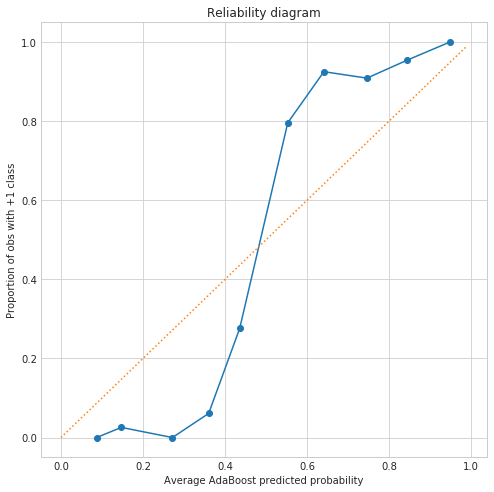

In [15]:
plt.figure(figsize=(8,8))
plt.plot(p_val_bins, y_val_bins, 'o-')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), ':')
plt.title('Reliability diagram')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')

Видим, что при `p_val < 0.5` AdaBoost систематически переоценивает вероятность принадлежности к классу +1, а при `p_val > 0.5` - систематически недооценивает. Это соответсвует скученному к центру распределению значений `p_val` - оцененной AdaBoost-ом вероятности принадлежности к классу +1 для наблюдений из валидационной выборки.

Такое поведение ответов классификатора приводит к тому, что калибровочная кривая становится очень похожа на сигмоиду. Именно поэтому здесь напрашивается использование калибровки Платта.

---
### Platt calibration

Калибровка Платта фитит сигмоиду на наши данные, используя в качестве единственного признака ответы классификатора:

$$P(y_i=1|f(x_i)) = \hat{y}_i= \frac{1}{1+e^{Af(x_i)+B}}$$

Здесь $A, B$ - константы, параметры которые мы подбираем на валидационной выборке чтобы как можно лучше описать данные, $f(x_i)$ - это ответ классификатора на $i$-ом наблюдении с признаками $x_i$. Эти ответы не обязательно должны быть вероятностями - вместо них можно использовать ненормированное расстояние до decision boundary, как это делается в SVM.


По факту получается, что мы фитим логистическую регрессию на данные $(f(x_i), y_i)$. Чтобы подобрать параметры $A, B$ используется метод максимального правдоподобия, что в свою очередь эквивалентно минимизации logloss:

$$L(y_i, \hat{y}_i) = - \frac{1}{n} \sum_{i=1}^n y_i\cdot \log(\hat{y}_i) + (1-y_i)\cdot\log(1-\hat{y}_i) \rightarrow \min$$

Минимизация может осуществляться с помощью градиентного спуска, для которого нужно вычислить частные производные по параметрам $A, B$: 

$$\frac{\partial L}{\partial A} = - \frac{1}{n} \sum_{i=1}^n \frac{y_i}{\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A}-\frac{1-y_i}{1-\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A}$$

$$\frac{\partial \hat{y}_i}{\partial A} = \frac{\partial}{\partial A}\left(\frac{1}{1+e^{Af(x_i)+B}}\right) = -\frac{f(x_i)\cdot e^{Af(x_i)+B}}{(1+e^{Af(x_i)+B})^2}$$

$$\frac{y_i}{\hat{y}_i} = y_i\cdot(1+e^{Af(x_i)+B})$$

$$\frac{1-y_i}{1-\hat{y}_i} = (1-y_i)\frac{1+ e^{Af(x_i)+B}}{e^{Af(x_i)+B}}$$

$$\frac{y_i}{\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A} = -\frac{y_i\cdot f(x_i)\cdot e^{Af(x_i)+B}}{1+e^{Af(x_i)+B}}$$

$$\frac{1-y_i}{1-\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A} = -\frac{(1-y_i)\cdot f(x_i)}{1+e^{Af(x_i)+B}}$$

$$\frac{y_i}{\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A}-\frac{1-y_i}{1-\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A} = -\frac{y_i\cdot f(x_i)\cdot e^{Af(x_i)+B}}{1+e^{Af(x_i)+B}} + \frac{f(x_i)}{1+e^{Af(x_i)+B}} - \frac{y_i\cdot f(x_i)}{1+e^{Af(x_i)+B}}$$

$$\frac{y_i}{\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A}-\frac{1-y_i}{1-\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A} = -\frac{y_i\cdot f(x_i)}{1+e^{Af(x_i)+B}}\left(e^{Af(x_i)+B} + 1\right)+ \frac{f(x_i)}{1+e^{Af(x_i)+B}}$$

$$\frac{y_i}{\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A}-\frac{1-y_i}{1-\hat{y}_i}\cdot\frac{\partial \hat{y}_i}{\partial A} = -y_i\cdot f(x_i) + f(x_i)\cdot\hat{y}_i = f(x_i)\cdot(\hat{y}_i  - y_i)$$

$$\frac{\partial L}{\partial A} = - \frac{1}{n} \sum_{i=1}^n f(x_i)\cdot(\hat{y}_i  - y_i)$$

$$\frac{\partial L}{\partial B} = - \frac{1}{n} \sum_{i=1}^n 1\cdot(\hat{y}_i  - y_i)$$

Заметим, что в каноническом определении Platt calibration используется именно нотация с $A, B$, и при этом не ставится знак минуса под экспонентой, в отличии от логистической регрессии. Дело в том, что в логистической регрессии знак минус перед $\sum_{k=1}^K x_{ik}w_k$ под экспонентой возникает из-за перехода от $\log(odds)$ к вероятностям:

$$\log\left(\frac{P(y_i=1|x_i)}{1-P(y_i=1|x_i)}\right) = \sum_{k=1}^K x_{ik}w_k$$

$$\frac{P(y_i=1|x_i)}{1-P(y_i=1|x_i)} = e^{\sum_{k=1}^K x_{ik}w_k}$$

$$\frac{1-P(y_i=1|x_i)}{P(y_i=1|x_i)} = \frac{1}{e^{\sum_{k=1}^K x_{ik}w_k}}$$

$$\frac{1}{P(y_i=1|x_i)} = \frac{1 + e^{\sum_{k=1}^K x_{ik}w_k}}{e^{\sum_{k=1}^K x_{ik}w_k}}$$

$$P(y_i=1|x_i) = \frac{1}{1+ e^{-\sum_{k=1}^K x_{ik}w_k}}$$

при этом коэффициенты $w$ сохраняют свою интерпретируемость: позитивный коэффициент позитивно влияет на таргет, аналогично для негативного.

В случае калибровки Платта, если не ставить явно минус, то при корректных формулах для лосса и градиента этот минус все равно будет включен в подобранные коэффициенты $A, B$. Поэтому важно за этим следить, если использовать для калибровки Платта готовую имплементацию логистической регресси: возвращаемые коэффициенты $w$ будут без минуса (т.е. будут иметь противоположный знак и сигмоида будет развернута зеркально (влево)).

Реализуем наши ручные расчеты в одном классе `PlattCalibration`:

In [16]:
class PlattCalibration():
    
    def sigmoid(self, x):
        return 1./(1+np.exp(x))
    
    def gradient_logloss(self, X, y, w, j):
        return - np.mean((self.sigmoid(np.dot(X, w)) - y)*X[:, j])
    
    def logloss(self, X, y, w):
        y_hat = self.sigmoid(np.dot(X, w))
        return - np.mean(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))

    def fit(self, true_y, predicted_y, tol=1e-5, step = 0.001):

        X = np.c_[predicted_y, np.ones(len(predicted_y))]

        w = np.array([0, 0])
        w_list = []
        logloss = []
        cnt = 1
        
        for _ in range(100000000):
            w_list.append(w)
            w_new = w - step*np.array([self.gradient_logloss(X, true_y, w, j=k) for k in range(2)])
            if np.linalg.norm(w_new - w)<tol:
                break
            w = w_new
            cnt+=1
            logloss.append(self.logloss(X, true_y, w))
            
        self.A = w[0]
        self.B = w[1]
        self.n_iter = cnt
        self.train_logloss = logloss
    
    def predict(self, x):
        return self.sigmoid(self.A*x+self.B)

In [17]:
platt = PlattCalibration()

И обучим на валидационном сете сигмоиду:

In [18]:
%%time
platt.fit(y_val, p_val, step=0.01)
print('Resulted coefficients:', platt.A, platt.B)
print('Total number of iterations:', platt.n_iter)
print('Minimized LogLoss value:', platt.train_logloss[-1])

Resulted coefficients: -16.301322851190523 7.9895281328322465
Total number of iterations: 280323
Minimized LogLoss value: 0.3706060266845078
CPU times: user 49.3 s, sys: 179 ms, total: 49.5 s
Wall time: 49.5 s


Text(0.5,0,'Iteration')

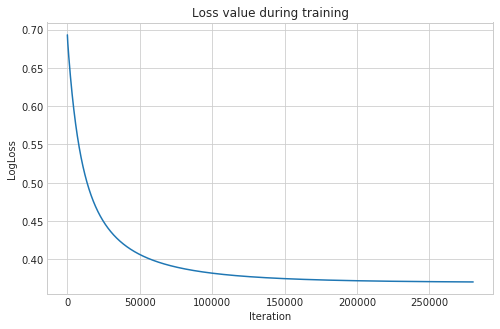

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(platt.train_logloss)
plt.title('Loss value during training')
plt.ylabel('LogLoss')
plt.xlabel('Iteration')

В результате обучения мы получили два значения для $A$ и $B$ соответственно. Еще раз отметим, что при обучении мы фитили сигмоиду на ответы классификатора AdaBoost, что эквивалентно обучению модели логистической регрессии на единственном признаке:

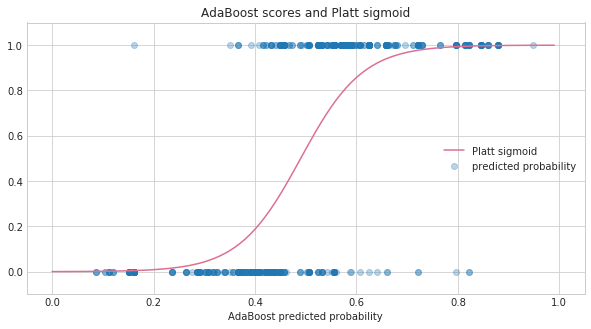

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(p_val, y_val, alpha=0.3, label='predicted probability')
x = np.arange(0, 1, 0.01)
plt.plot(x, platt.predict(x), color='palevioletred', label='Platt sigmoid')
plt.xlabel('AdaBoost predicted probability')
plt.title('AdaBoost scores and Platt sigmoid')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.1, 1.1)
plt.legend()

Изобразим полученную сигмоиду на reliability diagram:

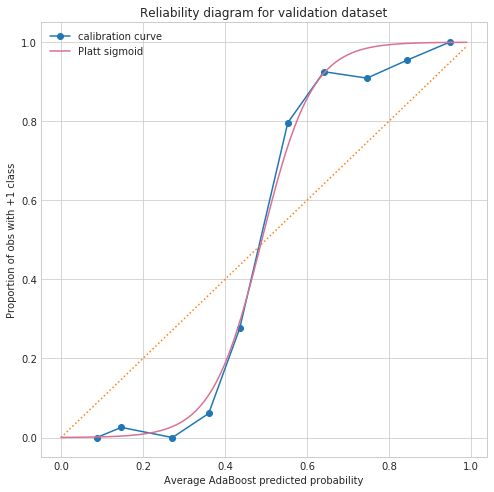

In [21]:
plt.figure(figsize=(8,8))
plt.plot(p_val_bins, y_val_bins, 'o-', label='calibration curve')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':')
plt.plot(x, platt.predict(x), color='palevioletred', label='Platt sigmoid')
plt.title('Reliability diagram for validation dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

Вертикальная координата точек калибровочной кривой показывает точную долю объектов класса +1 на валидационной выборке. Эти значения, понятно, могут варьироваться от выборки к выборке. Поэтому мы предполагаем, что истинная функциональная зависимость _доли объектов класса +1_ от _оцененной классификатором вероятности быть объектом класса +1_ в общем виде является сигмоидой, с параметрами $A, B$ найденными с помощью метода Платта (это справедливо как для набора фиксированных бинов, так и для каждого наблюдения в целом, ведь "фитили" сигмоиду мы на наблюдения (первый график)). Значения этой сигмоиды показывают долю объектов класса +1 при некотором значении предсказанной вероятности, т.е. сигмоида с найденными параметрами является маппингом из скоров классификатора в долю объектов класса +1, и эта зависимость имеет форму сигмоиды.

Чтобы откалибровать ответы классификатора, воспользуемся тестовой выборкой, которая до этого момента еще нигде не использовалась:

In [22]:
p_test_bins, y_test_bins = compute_calibration_curve(y_test, p_test)

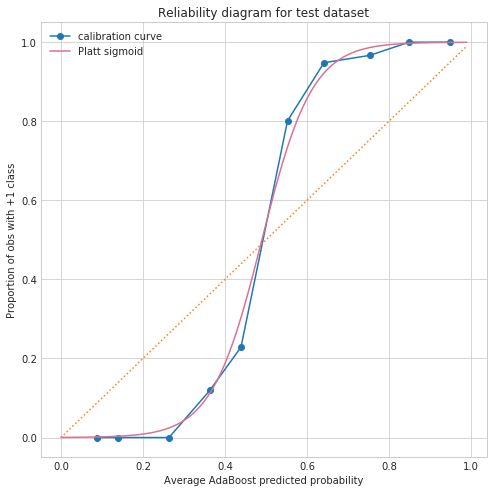

In [23]:
plt.figure(figsize=(8,8))
plt.plot(p_test_bins, y_test_bins, 'o-', label='calibration curve')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':')
plt.plot(x, platt.predict(x), color='palevioletred', label='Platt sigmoid')
plt.title('Reliability diagram for test dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

Тестовая и валидационная выборки очень похожи, поэтому и калибровочная кривая имеет аналогичный вид, и тоже почти совпадает с сигмоидой Платта.

Чтобы откалибровать тестовые ответы классификатора AdaBoost, нам нужно применить функцию найденной сигмоиды Платта к этим ответам:

$$\hat{y}_{calibrated} = \frac{1}{1+e^{Af(x)+B}} = \sigma_{A, B} (f(x))$$

Действительно, согласно калибровочной кривой, доля объектов класса +1 $P_{+1}$ (ось У) зависит _приблизительно_ сигмоидально от ответов классификатора $f(x)$ (ось Х). В метода Платта мы предполагаем что эта зависимость параметрическая:

$$P_{+1} = \sigma_{A, B} (f(x))$$

Из этого равенства видно, что трансформированные ответы классификатора равны доле объектов класса +1, и если мы изобразим эти трансформированные ответы классификатора на оси Х, а долю объектов класса +1 на оси У, то получится, что мы сравниваем одинаковые величины! Из чего следует, что точки выстроятся вдоль диагональной прямой, а значит трансформированные ответы классификатора будут откалиброваны. 

Иными словами, мы нашли функциональную зависимость между неоткалиброванными вероятностями (принадлежать классу +1) и истинной долей объектов класса +1, и используя эту зависимость можем эти неоткалиброванные вероятности трансформировать в "истинные" вероятности, которые, очевидно, сами с собой будут согласовываться и будут откалиброваны.

In [24]:
p_test_bins_calibrated, y_test_bins_calibrated = compute_calibration_curve(y_test, platt.predict(p_test))

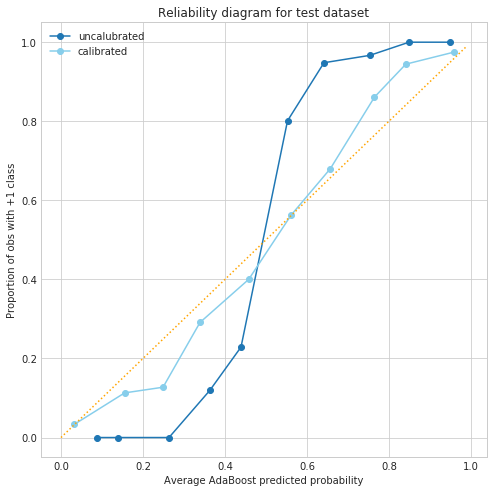

In [25]:
plt.figure(figsize=(8,8))
plt.plot(p_test_bins, y_test_bins, 'o-', label='uncalubrated')
plt.plot(p_test_bins_calibrated, y_test_bins_calibrated, 'o-', label='calibrated', color='skyblue')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':', color='orange')
plt.title('Reliability diagram for test dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

В силу того, что калибровочная кривая на тестовой выборке не идеально подчиняется подобранной сигмоиде, то и после применения этой сигмоиды, откалиброванные вероятности не будут лежать ровно на диагональной прямой.

Text(0.5,0,'Calibrated value of P(y=1|X)')

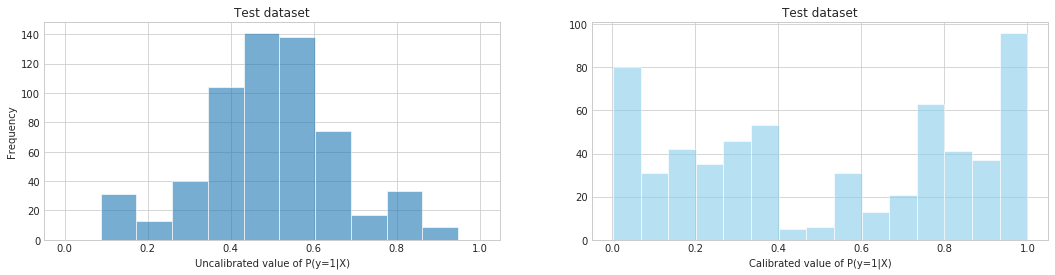

In [26]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(p_test, alpha=0.6, ec='white', bins=10)
plt.xlim(-0.05, 1.05)
plt.title('Test dataset')
plt.xlabel('Uncalibrated value of P(y=1|X)')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(platt.predict(p_test), alpha=0.6, ec='white', bins=15, color='skyblue')
plt.xlim(-0.05, 1.05)
plt.title('Test dataset')
plt.xlabel('Calibrated value of P(y=1|X)')

Сигмоида "растянула" скученные вероятности ближе к крайним значениям - нулю и единице. Это становится очевидно, если внимательно посмотреть на саму сигмоиду: неоткалиброванные вероятности в интервале $(0, 0.4)$ сигмоида трансформирует в очень узкий интервал калиброванных вероятностей около нуля. Аналогично для интервала около единицы. А скученные значения неоткалиброванных вероятностей около 0.5 она растягивает в широйкий интервал.

Отметим еще одну важную оговорку: полученное распределение калиброванных вероятностей (правая гистограмма) еще ничего не говорит на 100% о степени калиброванности самой модели; ведь то, что большая часть предсказанных вероятностей близка либо к нулю, либо к единице еще не гарантирует, что истинная доля объектов класса +1 согласуется с этими значениями. Поэтому важно проверять калиброванность с помощью reliability diagram или scoring rules.

---
### Isotonic regression

Монотонная регрессия фитит кусочно-постояную функцию на входные данные. В калибровке в качестве входных данных используются ответы классификатора $f(x)$. Воспользуемся готовой имплементацией в `sklearn` и обучим монотонную регрессию на валидационной выборке:

In [27]:
isotonic = IsotonicRegression(y_min=0, y_max=1)
isotonic.fit(p_val, y_val)

IsotonicRegression(increasing=True, out_of_bounds='nan', y_max=1, y_min=0)

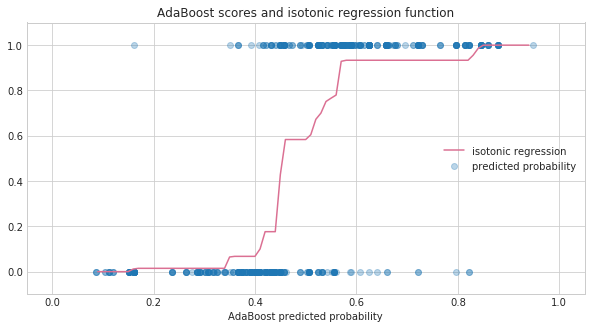

In [28]:
plt.figure(figsize=(10,5))
plt.scatter(p_val, y_val, alpha=0.3, label='predicted probability')
x = np.arange(0, 1, 0.01)
plt.plot(x, isotonic.predict(x), color='palevioletred', label='isotonic regression')
plt.xlabel('AdaBoost predicted probability')
plt.title('AdaBoost scores and isotonic regression function')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.1, 1.1)
plt.legend()

В нашей задаче калибровочная кривая сильно похожа на сигмоиду, поэтому даже если не использовать непосредственно параметрическую функцию для описания зависимости между ответами классификатора и долей объектов класса +1, мы все равно получим функцию похожую на сигмоиду. 

Изобразим полученную функцию на reliability diagram:

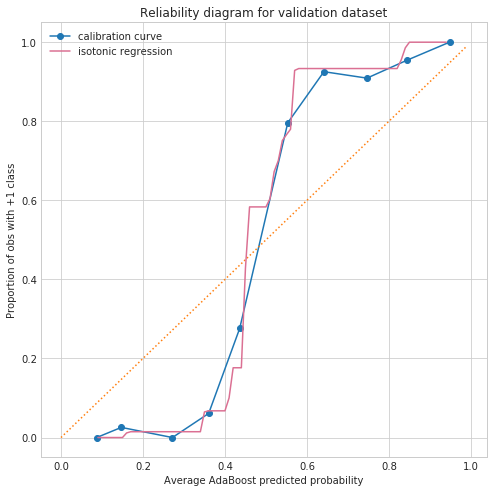

In [29]:
plt.figure(figsize=(8,8))
plt.plot(p_val_bins, y_val_bins, 'o-', label='calibration curve')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':')
plt.plot(x, isotonic.predict(x), color='palevioletred', label='isotonic regression')
plt.title('Reliability diagram for validation dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

Если мы откалибруем валидационную выборку (ту, на которой мы обучали калибровку), то мы ожидаемо получим идеальную диагональную прямую, так как при обучении мы выучиваем маппинг из предсказанной вероятности в истинную (долю объектов класса $+1$). Аналогично будет и с сигмоидой, но так как там мы испоьзуем параметрическую модель, то она фитится на наши данные не идеально, так как маппинг, который мы выучиваем, подчиняется сигмоиде, функциональной зависимости, а не точечным данным как в монотонной регрессии. Именно поэтому метод калибровки с помощью монотонной регрессии легче переобуается и подстраивается под данные, поэтому для него необходимо иметь много наблюдений.

In [30]:
p_val_bins_calibrated, y_val_bins_calibrated = compute_calibration_curve(y_val, isotonic.predict(p_val))

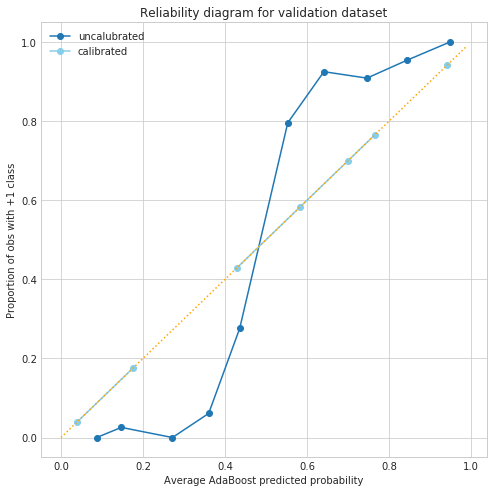

In [31]:
plt.figure(figsize=(8,8))
plt.plot(p_val_bins, y_val_bins, 'o-', label='uncalubrated')
plt.plot(p_val_bins_calibrated, y_val_bins_calibrated, 'o-', label='calibrated', color='skyblue')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':', color='orange')
plt.title('Reliability diagram for validation dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

Чтобы откалибровать ответы классификатора, воспользуемся тестовой выборкой, которая до этого момента еще нигде не использовалась:

In [32]:
p_test_bins_calibrated, y_test_bins_calibrated = compute_calibration_curve(y_test, isotonic.predict(p_test))

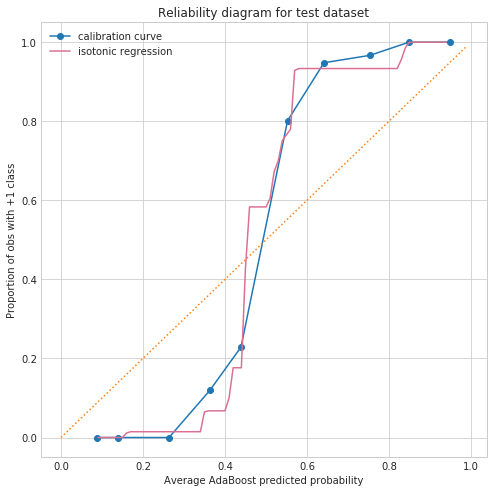

In [33]:
plt.figure(figsize=(8,8))
plt.plot(p_test_bins, y_test_bins, 'o-', label='calibration curve')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':')
plt.plot(x, isotonic.predict(x), color='palevioletred', label='isotonic regression')
plt.title('Reliability diagram for test dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

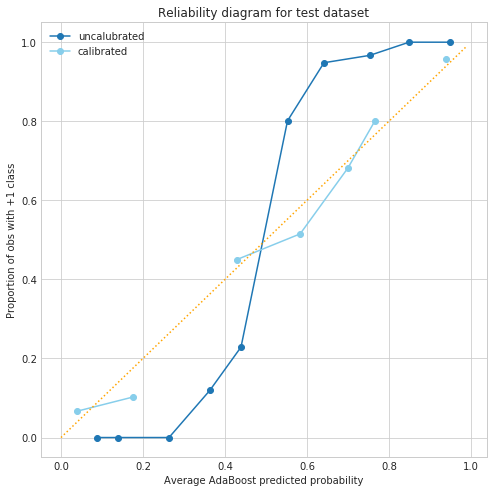

In [34]:
plt.figure(figsize=(8,8))
plt.plot(p_test_bins, y_test_bins, 'o-', label='uncalubrated')
plt.plot(p_test_bins_calibrated, y_test_bins_calibrated, 'o-', label='calibrated', color='skyblue')
x = np.arange(0, 1, 0.01)
plt.plot(x, x, ':', color='orange')
plt.title('Reliability diagram for test dataset')
plt.xlabel('Average AdaBoost predicted probability')
plt.ylabel('Proportion of obs with +1 class')
plt.legend()

Text(0.5,0,'Calibrated value of P(y=1|X)')

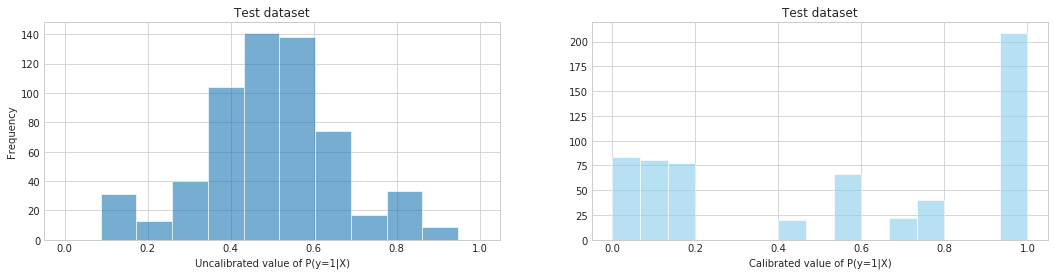

In [35]:
plt.figure(figsize=(18,4))

plt.subplot(121)
plt.hist(p_test, alpha=0.6, ec='white', bins=10)
plt.xlim(-0.05, 1.05)
plt.title('Test dataset')
plt.xlabel('Uncalibrated value of P(y=1|X)')
plt.ylabel('Frequency')

plt.subplot(122)
plt.hist(isotonic.predict(p_test), alpha=0.6, ec='white', bins=15, color='skyblue')
plt.xlim(-0.05, 1.05)
plt.title('Test dataset')
plt.xlabel('Calibrated value of P(y=1|X)')

Для избежания проблем с "отсутствующими" точками на калибровочной кривой нужно воспользоваться не равномерной по значениям вероятности генерацией бинов, а "равномощной" - с равными по количеству наблюдений бинами.